In [ ]:
import numpy as np
import pandas as pd
import os
import glob as gb
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/capstone/segmentation/fs/fs')

%matplotlib inline
import utils_nails
from utils_nails import *

# datasetpath='/content/gdrive/MyDrive/capstone/segmentation/fs/fs/nails.tar.gz'

import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

In [ ]:
TRAIN_PATH ='/content/gdrive/MyDrive/capstone/segmentation/fs/fs/archive/nails_segmentation/images/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_train[n] = img 

100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


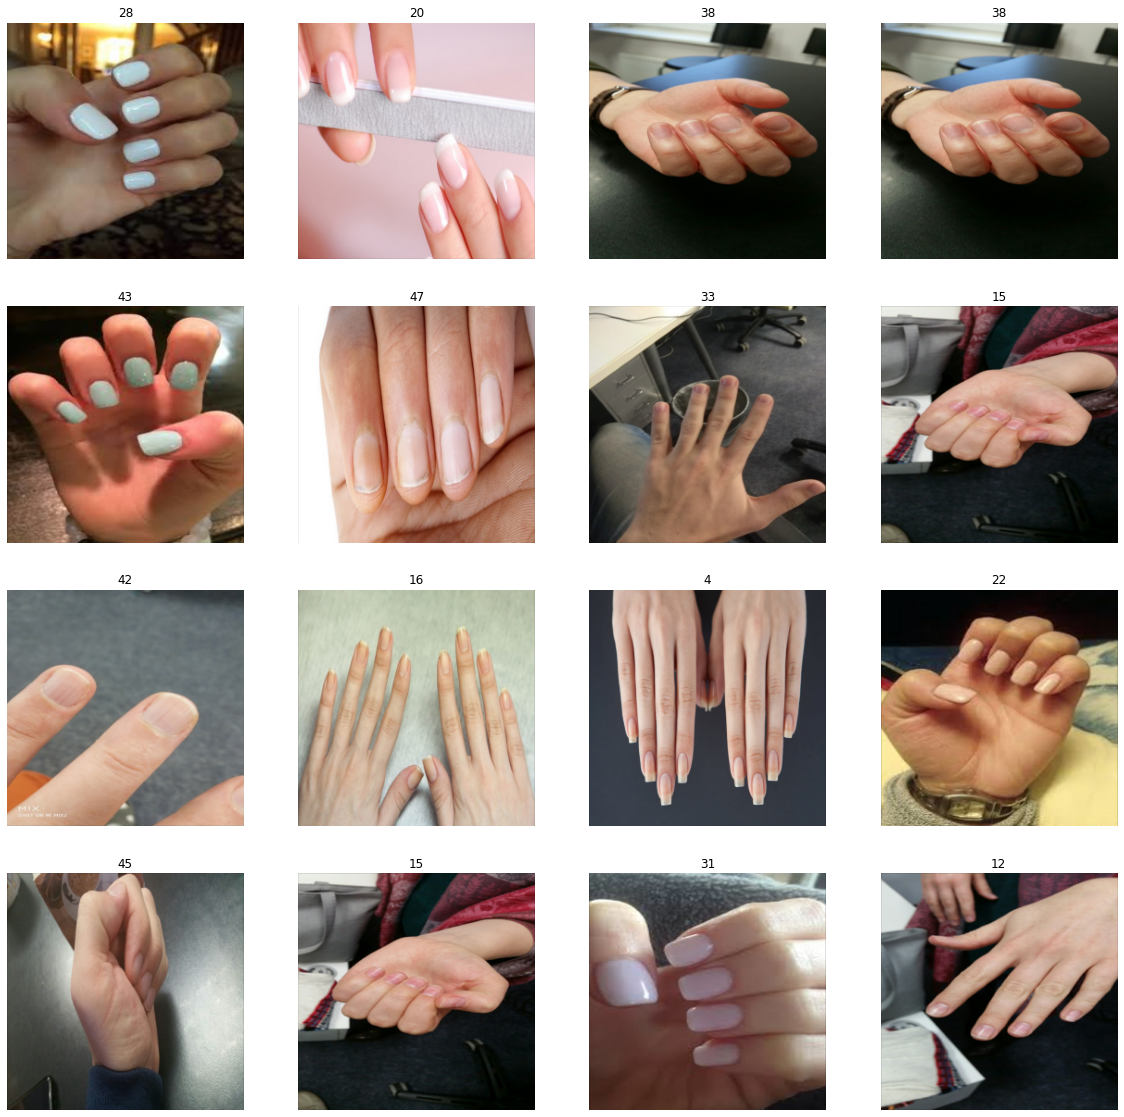

In [ ]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(i)

In [ ]:
TRAIN_PATH ='/content/gdrive/MyDrive/capstone/segmentation/fs/fs/archive/nails_segmentation/labels/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    mask = imread(id_)[:,:,:1] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = mask 

100%|██████████| 52/52 [00:18<00:00,  2.80it/s]


TypeError: ignored

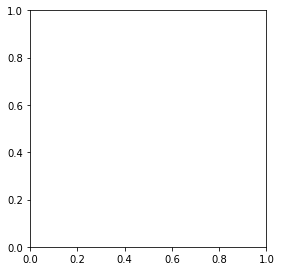

In [ ]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [ ]:
import tensorflow
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose

In [ ]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    
    #Expansive path 
    
     
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    
    return model

In [ ]:
model=unet(256,256,3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 64) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 36928       dropout_5[0][0]                  
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=8,steps_per_epoch=len(X_train)//8,epochs=50,
                 callbacks=callback,verbose=1,shuffle=True)

Epoch 1/50
6/6 [==============================] - 173s 28s/step - loss: 33.3657 - accuracy: 0.8485 - val_loss: 9.5042 - val_accuracy: 0.9564

Epoch 00001: val_loss improved from inf to 9.50416, saving model to model.hdf5
Epoch 2/50
6/6 [==============================] - 167s 28s/step - loss: 8.1923 - accuracy: 0.8851 - val_loss: 3.2575 - val_accuracy: 0.9608

Epoch 00002: val_loss improved from 9.50416 to 3.25752, saving model to model.hdf5
Epoch 3/50
6/6 [==============================] - 167s 28s/step - loss: 3.5064 - accuracy: 0.8930 - val_loss: 0.9999 - val_accuracy: 0.9609

Epoch 00003: val_loss improved from 3.25752 to 0.99989, saving model to model.hdf5
Epoch 4/50
6/6 [==============================] - 167s 28s/step - loss: 2.2467 - accuracy: 0.9007 - val_loss: 0.3711 - val_accuracy: 0.9600

Epoch 00004: val_loss improved from 0.99989 to 0.37106, saving model to model.hdf5
Epoch 5/50
6/6 [==============================] - 167s 28s/step - loss: 1.3444 - accuracy: 0.8991 - val_los

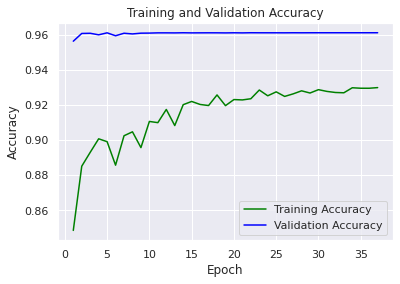

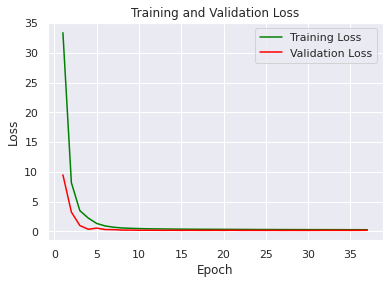

In [ ]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
y_pred=model.predict(X_train)
y_pred_1=(y_pred > 0.6).astype(np.uint8)

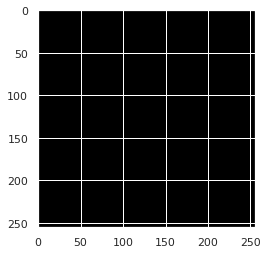

In [ ]:
plt.imshow(y_pred_1[5][:,:,-1],cmap='gray')
plt.show()

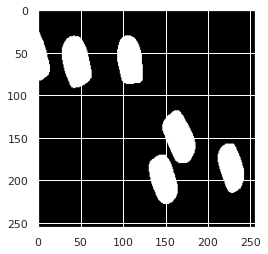

In [ ]:
plt.imshow(Y_train[5][:,:,-1],cmap='gray')
plt.show()